### Notebook on the implementation of VQLS
- Equation to solve $Ax=b$
- Matrix $A$ assumed to be Hermitian and real
- $b$ assumed real 

In [213]:
#Packages and libraries:
from scipy.optimize import minimize
import qiskit_aer
from qiskit import QuantumCircuit, quantum_info
from qiskit.circuit import Parameter
from qiskit.visualization import array_to_latex,plot_bloch_multivector,plot_state_qsphere,plot_distribution
from qiskit.visualization import plot_circuit_layout,plot_error_map

from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.result import marginal_counts


from qiskit.circuit.random import random_circuit
from qiskit import transpile
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import random
# from qiskit_algorithms.optimizers import COBYLA

from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.providers.fake_provider import GenericBackendV2

#for running on real q-computers:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
plt.rcParams["figure.figsize"] = (6.0, 4.0)   # width, height in inches
plt.rcParams["figure.dpi"]     = 300 

### Define the problem ($A$ real and Hermitian):

In [214]:
#DEFINE 8x8 matrix 

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
pauli_mat = {0: I, 1: Z, 2: X}

def kron3(code):
    return np.kron(np.kron(pauli_mat[code[2]], pauli_mat[code[1]]), pauli_mat[code[0]]) #ORDER IN PAULI MARTICES!!!!!
    
# A =  0.7 (IIZ)  + 0.4 (XII)  – 0.3 (ZXX)  + 0.2 (IXI)  + 0.1 (XXX)

"""chosen_terms = {
     (0,0,1):  0.7,    # I ⊗ I ⊗ Z
     (2,0,0):  0.4,    # X ⊗ I ⊗ I
     (1,2,2): -0.3,    # Z ⊗ X ⊗ X
     (0,2,0):  0.2,    # I ⊗ X ⊗ I
     (2,2,2):  0.1,    # X ⊗ X ⊗ X
 }"""

chosen_terms = {
    (0,0,1):  0.7,    # I ⊗ I ⊗ Z
    (2,2,2):  0.1,    # X ⊗ X ⊗ X
    (2,1,2):  -0.4,    # X ⊗ Z ⊗ X
}


A = sum(c * kron3(code) for code, c in chosen_terms.items())
b = np.array([1,1,1,1,1,1,1,1])  
Nparam=len(chosen_terms) #number of non-zero coefficients
display(array_to_latex(A,prefix="A="))
xsol=sp.linalg.solve(A,b)
display(array_to_latex(xsol,prefix="x_{sol}="))
xsol_norm=xsol/sp.linalg.norm(xsol)
display(array_to_latex(xsol_norm,prefix="x_{sol;norm}="))
Nqubits=int(np.log2(len(A)))# for n-qubit register

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Now we define the different pieces for VQLS:
- Ansatz
- Hadamard test
- U gate that maps $|0\rangle$ into $|b\rangle$

In [215]:
def ansatz(nq,param): #this is now hard coded, works for 3 qubits.
    var=QuantumCircuit(nq)
    for ii in range(0,nq):
        var.ry(param[0][ii],ii )

    for ii in range(0,nq-1):
        var.c(0, ii+1)

    for ii in range(0, nq):
        var.ry(param[1][ii], ii)

    for ii in range(0,nq-1):
        var.cz(ii,nq-1)

    for ii in range(0, nq):
        var.ry(param[2][ii], ii)
    Vtheta=var.to_gate(label='V(θ)')
    return Vtheta

def HadamardTest(nq,Ugate): #performs Hadamard test for a generic gate U that acts on nq qubits. First qubit aux
    qc=QuantumCircuit(nq+1,1)
    c_Ugate=Ugate.control()
    qc.h(0)
    qc.append(c_Ugate,range(nq+1))
    qc.h(0)
    qc.measure(0,0)
    return qc

def Utob(b):
    b/=sp.linalg.norm(b)
    nq=int(np.log2(len(b)))
    Ub=Initialize(b)
    Ubdag=Ub.gates_to_uncompute()
    return Ub,Ubdag

In [282]:
def run_fake(qc,backend = GenericBackendV2(2),Nshots=1024,optim=2):
    qc_transpiled = transpile(qc, backend) 
    job = backend.run(qc_transpiled, shots = 1024, noise_model = None)
    counts = job.result().get_counts()

    return counts

In [283]:
#Define the problem using An and cn: A=sum_n c_n A
An=np.zeros([Nparam,len(b),len(b)])
cn=np.zeros([Nparam])
ii=0
for code,c in chosen_terms.items():
    An[ii]=kron3(code)
    cn[ii]=c
    ii+=1
b=np.asarray(b,dtype=float)
Ub,Ubdag=Utob(b)

ValueError: could not broadcast input array from shape (8,8) into shape (2,2)

**Now we perform the VQLS, where we need to estimate the parameters $\Lambda_{n,m}$ and $\Gamma_{n}$ as defined in the notes (see overleaf, workplan)**. For that, we employ the Hadamard test, leading into $N+N(N-1)/2$ tests being $N$ the number of non-zero coefficients in the expansion of $A$. 

In [284]:
def VQLS_iter(An,cn,param,Nshots=1024):
    nq=int(np.log2(len(A[0])))
    Vtheta=ansatz(nq,param)
    
    ## Cmpute the \Lambda_{n,m}:
    Lambda_nm=np.identity(Nparam)
    for ii in range(Nparam):
        Lambda_nm[ii,ii]=np.conjugate(cn[ii])*cn[ii]

    for ii in range(Nparam-1):
        for jj in range(ii+1,Nparam):
            qc=QuantumCircuit(nq)
            qc.append(Vtheta,range(nq))
            qc.unitary(An[ii],range(nq))
            qc.unitary(np.transpose(np.conjugate(An[jj])),range(nq))
            qc.append(Vtheta.inverse(),range(nq))
            Uaux=qc.to_gate()
            qc_aux=HadamardTest(nq,Uaux)
            counts_aux=run_fake(qc_aux,Nshots=Nshots)
            p0=0
            if '0' in counts_aux.keys():
                p0=counts_aux.get('0')/Nshots
            Lambda_nm[ii,jj]=(2*p0-1)*np.conjugate(cn[ii])*cn[jj]
            Lambda_nm[jj,ii]=Lambda_nm[ii,jj]
            
    ## Compute Gamma_n
    Gamma_n=np.zeros([Nparam])
    for ii in range(Nparam):
        qc=QuantumCircuit(nq)
        qc.append(Vtheta,range(nq))
        qc.unitary(An[ii],range(nq))
        qc.append(Ubdag,range(nq))
        Uaux=qc.decompose().to_gate()
        qc_aux=HadamardTest(nq,Uaux)
        counts_aux=run_fake(qc_aux,Nshots=Nshots)
        p0=0
        if '0' in counts_aux.keys():
           p0=counts_aux.get('0')/Nshots
        Gamma_n[ii]=cn[ii]*(2*p0-1)

    fidelity=0
    for ii in range(Nparam):
        for jj in range(Nparam):
            fidelity+=Gamma_n[ii]*Gamma_n[jj]
    fidelity=fidelity/sum(sum(Lambda_nm))    
    return fidelity

def cost_function(flat_param): #note that changing A (and the corresponding An and cn requires recompilation of this function
    param_matrix = flat_param.reshape((3, 3))
    cost_val = 1 - VQLS_iter(An,cn, param_matrix)
    cost_history.append(cost_val)
    print(cost_val)
    return cost_val
    

In [157]:
cost_history=[]
res=sp.optimize.minimize(cost_function,x0 = np.random.uniform(0, 2*np.pi, size=9),method='COBYLA',tol=1e-2,options={'rhobeg':np.pi/5,'maxiter':100, 'disp': True})

0.9987248296408733
0.9998819416156659
0.9998638835114474
0.9994212002581786
0.9983006949476548
0.9998163182416807
0.9996646656430777
0.9973611801097428
0.9995137014487117
0.9996553286900105
0.9999992888388793
0.9998929541651239
0.9997104134917874
0.9999998409967708
0.9975262756662715
0.9992524912382608
0.9996857407069443
0.9997638088658578
0.9997821212864896
0.9977433535940139
0.9962490791767776
0.9996756932057727
0.9990083540670681
0.9994223593797411
0.9947946417479441
0.9996254781045668
0.9998305399401021
0.9998596678419002
0.998840156698851
0.9937953189246531
0.999760239063191
0.9998436162967493
0.9990044904180284
0.9999630144958723
0.9999620592602998
0.9975282727501473
0.9999995287861169
0.9982576312404633
0.9975699101067517
0.9995912113691341
0.9977743670984135
0.9973937214260864
0.999912902965746
0.998940976769488
0.9998561997282338
0.9999923435386817
0.9982596645411491
0.9991798346080677


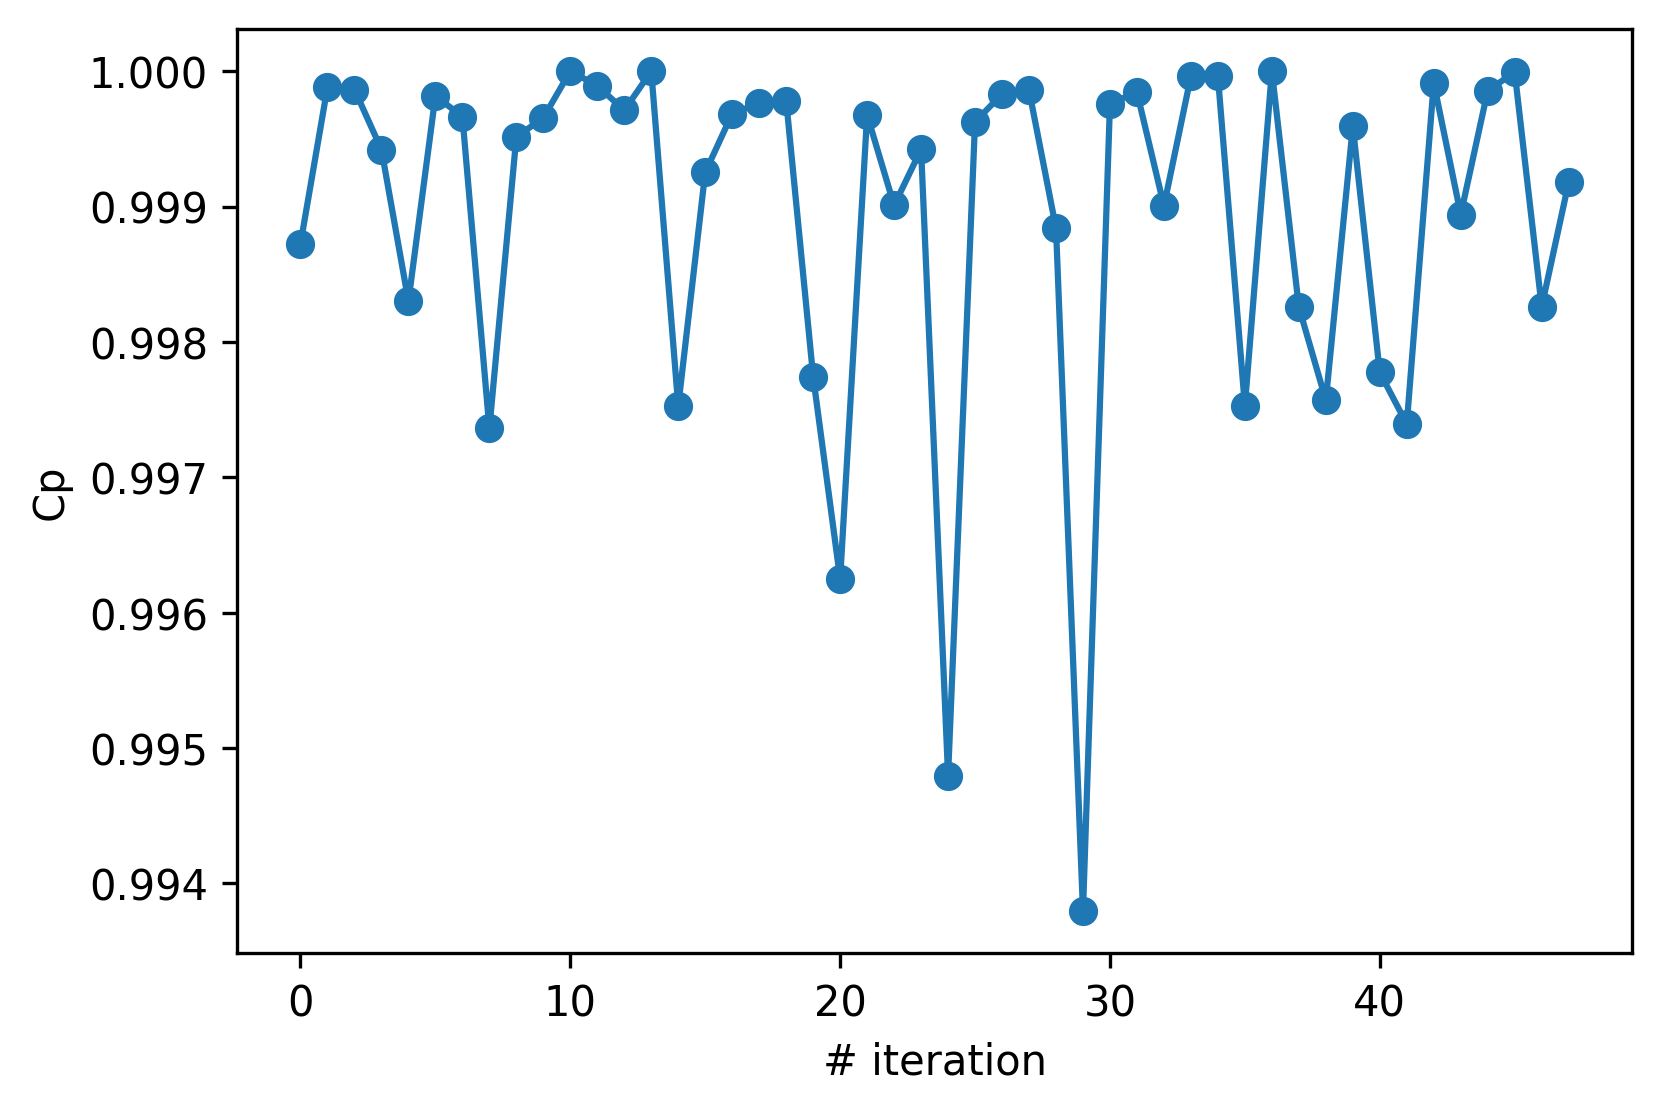

In [158]:
fig, ax1 = plt.subplots()
ax1.plot(cost_history, 'o-')
ax1.set_xlabel("# iteration")
ax1.set_ylabel("Cp")
plt.show()

In [159]:
fig.savefig("vqls_conv_fake2", dpi=300, bbox_inches="tight")

In [160]:
#Now, let us check the solution found by VQLS:
Vthetasol=ansatz(Nqubits,res.x.reshape((3,3)))
qc=QuantumCircuit(Nqubits)
qc.append(Vthetasol,range(Nqubits))
psisol=quantum_info.Statevector(qc)
print(psisol)
print(xsol_norm)
#print(psisol@xsol_norm)
from qiskit.quantum_info import state_fidelity
fidelity = state_fidelity(psisol, xsol_norm)
fidelity

Statevector([ 0.13404295+0.j, -0.09184372+0.j, -0.17408079+0.j,
              0.13857863+0.j, -0.50432171+0.j,  0.19965943+0.j,
              0.73187131+0.j, -0.30700027+0.j],
            dims=(2, 2, 2))
[0.04975186 0.04975186 0.04975186 0.04975186 0.4975186  0.4975186
 0.4975186  0.4975186 ]


0.003616733273779784

### Simple case (to compare with HHL):


In [363]:
#Define the problem using An and cn: A=sum_n c_n A
Nparam=2
Nqubit=1
b=np.array([0,1])
An=np.zeros([Nparam,len(b),len(b)])
cn=np.zeros([Nparam])
An[0]=I
An[1]=X
cn[0]=1
cn[1]=-1/3
A=cn[0]*An[0]+cn[1]*An[1]
xsol=sp.linalg.solve(A,b)
display(array_to_latex(xsol,prefix="x_{sol}="))
xsol_norm=xsol/sp.linalg.norm(xsol)
display(array_to_latex(xsol_norm,prefix="x_{sol;norm}="))

b=np.asarray(b,dtype=float)
Ub,Ubdag=Utob(b)

def run_fake(qc,backend = GenericBackendV2(Nqubit+1),Nshots=1024,optim=2):
    qc_transpiled = transpile(qc, backend) 
    job = backend.run(qc_transpiled, shots = 1024)
    counts = job.result().get_counts()

    return counts
xsol_norm

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([0.31622777, 0.9486833 ])

Note that this requires a modification of the Ansatz:

In [364]:
def ansatz1(param): #this is now hard coded, just 1 qubit.
    var=QuantumCircuit(1)
    var.ry(param[0],0)
    Vtheta=var.to_gate(label='V(θ)')
    return Vtheta

In [365]:
def VQLS1_iter(An,cn,param,Nshots=1024):
    nq=int(np.log2(len(A[0])))
    Vtheta=ansatz1(param)
    
    ## Cmpute the \Lambda_{n,m}:
    Lambda_nm=np.identity(Nparam)
    for ii in range(Nparam):
        Lambda_nm[ii,ii]=np.conjugate(cn[ii])*cn[ii]

    for ii in range(Nparam-1):
        for jj in range(ii+1,Nparam):
            qc=QuantumCircuit(nq)
            qc.append(Vtheta,range(nq))
            qc.unitary(An[ii],range(nq))
            qc.unitary(np.transpose(np.conjugate(An[jj])),range(nq))
            qc.append(Vtheta.inverse(),range(nq))
            Uaux=qc.to_gate()
            qc_aux=HadamardTest(nq,Uaux)
            counts_aux=run_fake(qc_aux,Nshots=Nshots)
            p0=0
            if '0' in counts_aux.keys():
                p0=counts_aux.get('0')/Nshots
            Lambda_nm[ii,jj]=(2*p0-1)*np.conjugate(cn[ii])*cn[jj]
            Lambda_nm[jj,ii]=Lambda_nm[ii,jj]
            
    ## Compute Gamma_n
    Gamma_n=np.zeros([Nparam])
    for ii in range(Nparam):
        qc=QuantumCircuit(nq)
        qc.append(Vtheta,range(nq))
        qc.unitary(An[ii],range(nq))
        qc.append(Ubdag,range(nq))
        Uaux=qc.decompose().to_gate()
        qc_aux=HadamardTest(nq,Uaux)
        counts_aux=run_fake(qc_aux,Nshots=Nshots)
        p0=0
        if '0' in counts_aux.keys():
           p0=counts_aux.get('0')/Nshots
        Gamma_n[ii]=cn[ii]*(2*p0-1)

    fidelity=0
    for ii in range(Nparam):
        for jj in range(Nparam):
            fidelity+=Gamma_n[ii]*Gamma_n[jj]
    fidelity=fidelity/sum(sum(Lambda_nm))    
    return fidelity
def cost1_function(param): #note that changing A (and the corresponding An and cn requires recompilation of this function
    cost_val = 1 - VQLS1_iter(An,cn, param)
    cost1_history.append(cost_val)
    print(cost_val)
    return cost_val


In [372]:
cost1_history=[]
res=sp.optimize.minimize(cost1_function,x0 = np.random.uniform(0, 2*np.pi, size=1),method='COBYLA',tol=1e-2,options={'rhobeg':np.pi/10,'maxiter':100, 'disp': True})

0.2685813601321587
0.04991983119933696
0.10316879254779843
0.12594377468729423
0.09729516806722704
0.2311242508561645
0.18939177775748728
0.06478191739949757


In [373]:
Vthetasol=ansatz1(res.x)
qc=QuantumCircuit(1)
qc.append(Vthetasol,[0])
psisol=quantum_info.Statevector(qc)
print(psisol)
print(xsol_norm)
print(psisol@xsol_norm)

Statevector([0.45093615+0.j, 0.89255621+0.j],
            dims=(2,))
[0.31622777 0.9486833 ]
(0.9893516998682195+0j)


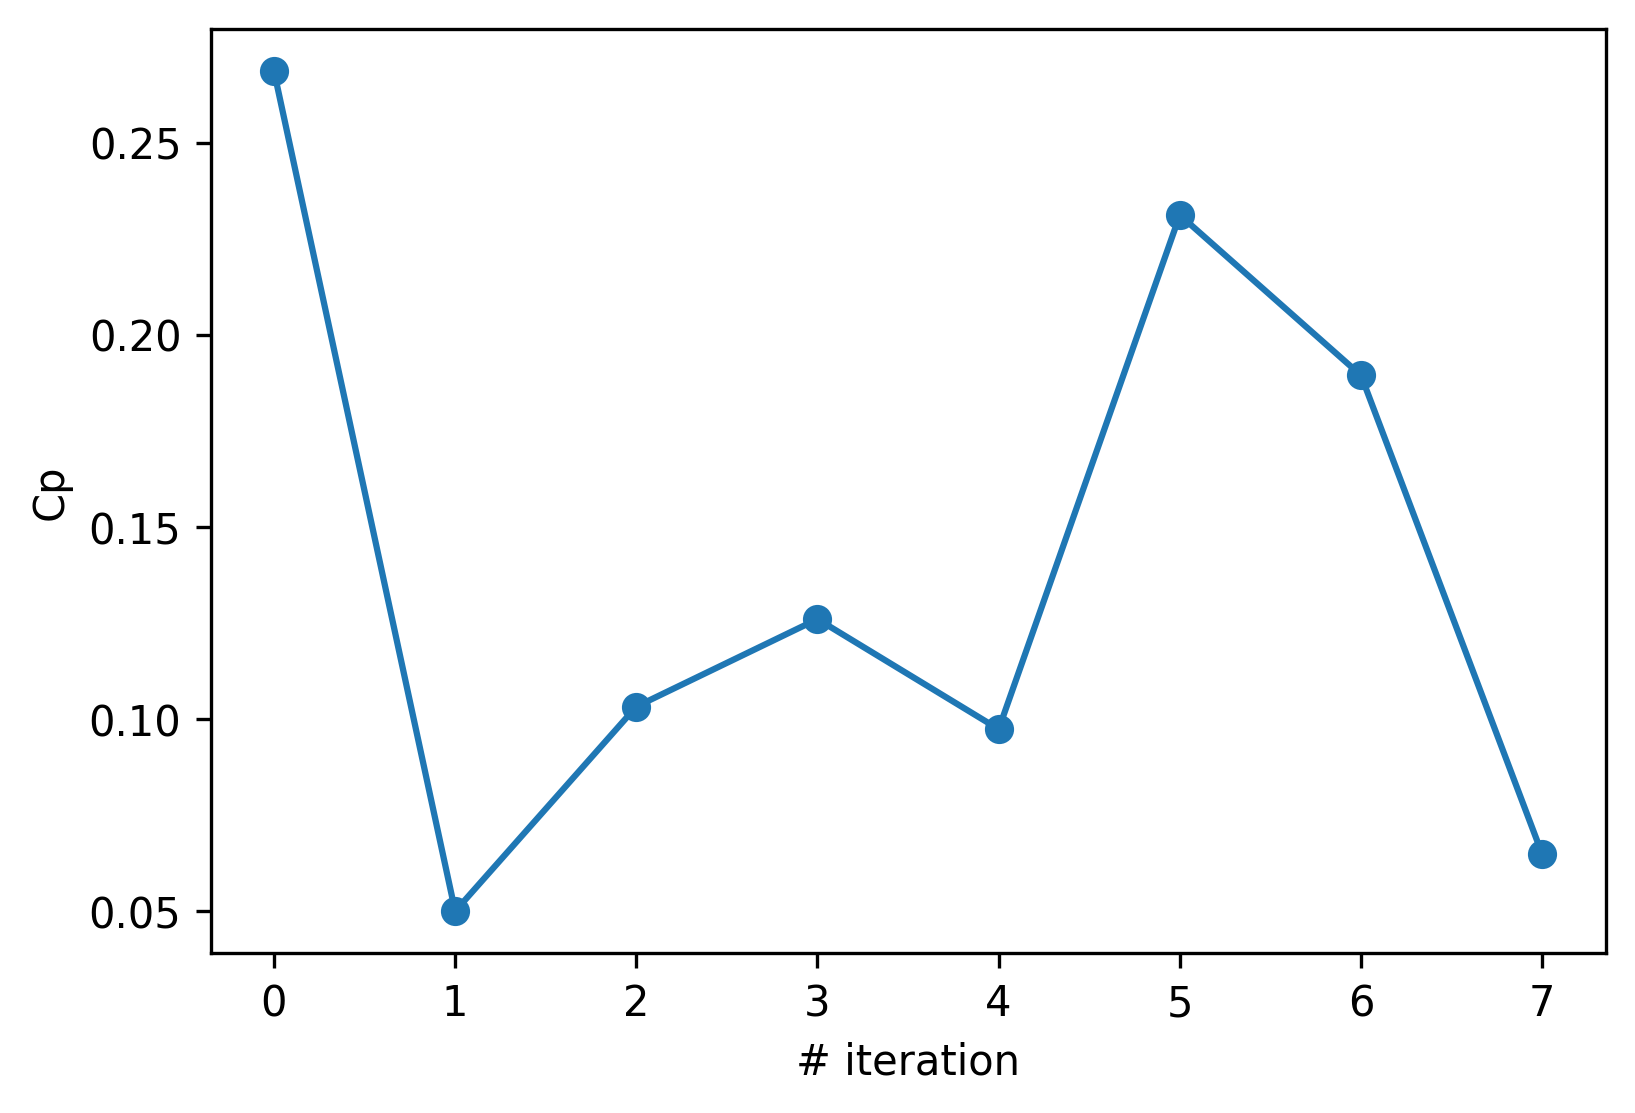

In [374]:
fig, ax2 = plt.subplots()
ax2.plot(cost1_history, 'o-')
ax2.set_xlabel("# iteration")
ax2.set_ylabel("Cp")
plt.show()

In [375]:
fig.savefig("vqls_conv_ideal3HHLCOMP", dpi=300, bbox_inches="tight")
state_q = Statevector.from_instruction(qc)
fidelity = abs(np.vdot(xsol_norm, state_q.data))**2
print("Fidelity:" ,fidelity)
print(res.fun)
psisol=quantum_info.Statevector(qc)
print(psisol)
print(xsol_norm)
print(psisol@xsol_norm)

Fidelity: 0.9788167860321354
0.06478191739949757
Statevector([0.45093615+0.j, 0.89255621+0.j],
            dims=(2,))
[0.31622777 0.9486833 ]
(0.9893516998682195+0j)
